In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.io import imread, imsave

from extend import extend_image, load_model
from utils import MaskPosition

from skimage.color import rgb2lab, lab2rgb
from pathlib import Path

Detectron v2 is not installed


In [2]:
%matplotlib inline

In [3]:
model = load_model()

In [9]:
data_dir = '../../voronoi/example'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [10]:
def extend_fragment(fragment, mask, extended_mask, model):
    """
    fragment: np.array fragment to be extended
    mask: np.array mask of the fragment
    extended_mask: np.array mask of the extended fragment
    model - model to be used for extending
    return: np.array extended fragment
    """
    inv_mask = np.invert(mask.astype(bool))
    inv_mask = cv2.dilate(inv_mask * 1.0, np.ones((3, 3)))[:, :, None].astype(bool)
    extended = extend_image(fragment, inv_mask, model) * extended_mask
    return extended

In [11]:
def find_crop_params(mask, ext_step=30):    
    top = np.where(mask)[0].min() - ext_step
    left = np.where(mask)[1].min() - ext_step
    bottom = np.where(mask)[0].max() + ext_step
    right = np.where(mask)[1].max() + ext_step
    return MaskPosition(top, bottom, left, right)

In [12]:
def read_fragment(data_dir: str, mask_index: int, model, ext_step=30):
    fresco = imread(f'{data_dir}/fresco.jpg')
    mask_name = data_dir + '/' + f'new_mask_{mask_index}.png'    
    mask = imread(mask_name) > 0.9
    mask = cv2.erode(mask[:, :, 0] * 1.0, np.ones((4, 4), np.uint8))[:,:,None].astype(bool)
    frag = fresco * mask
    extended_mask = cv2.dilate(mask * 1.0, np.ones((20, 20)))[:, :, None].astype(bool)
    
    crop_params = find_crop_params(mask, ext_step)
    frag = frag[crop_params.top:crop_params.bottom, crop_params.left:crop_params.right]
    mask = mask[crop_params.top:crop_params.bottom, crop_params.left:crop_params.right]
    extended_mask = extended_mask[crop_params.top:crop_params.bottom, crop_params.left:crop_params.right]
    extended_frag = extend_fragment(frag, mask, extended_mask, model)
#     extended_frag = frag
    return frag, extended_frag, mask, extended_mask
    
    
    

In [13]:
frag, extended_frag, mask, extended_mask = read_fragment(data_dir, 14, model)

In [14]:
extended_frag.max()

1.0

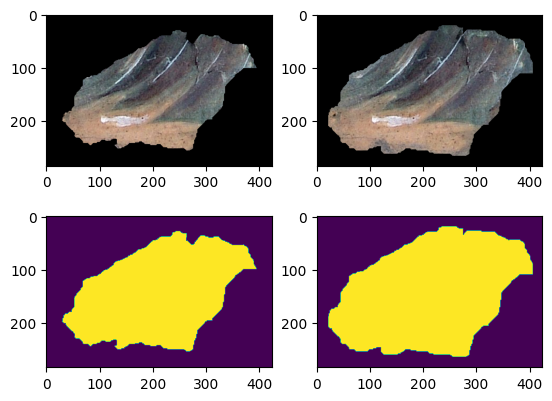

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].imshow(frag)
axes[0, 1].imshow(extended_frag)
axes[1, 0].imshow(mask[:, :, 0])
axes[1, 1].imshow(extended_mask[:, :, 0])

In [17]:
from skimage.color import rgb2lab
from color_dsc_operations import ColorDescriptor
from quantization import get_colors_from_masked_image

def compute_color_dsc(img, mask, palette):
    """
    img: np.array image to be masked and to provide color histograms
    mask: np.array
    palette: np.array of shape (M, 3) - color centers from the LAB space
    return: ColorDescriptor if index is valid else None
    """
    lab_img = rgb2lab(img)
    colors = get_colors_from_masked_image(lab_img, mask) # shape (3, n)
    b = np.mean(colors, axis=1)
    dists = np.array([
        np.linalg.norm(colors - palette[i][None, :], axis=1).reshape((colors.shape[0],))
        for i in range(palette.shape[0])
    ]) ** 2 # shape (M, N)
    closest = dists.argmin(axis=0)
    h = np.histogram(closest, bins=[i - 0.5 for i in range(palette.shape[0] + 2)])[0]
    variances = np.array([
        np.mean((dists[i] * (closest == i)))
        for i in range(palette.shape[0])
    ])
    return ColorDescriptor(h, b, np.sqrt(variances))

In [18]:
color_dsc = compute_color_dsc(frag, mask, palette)

<BarContainer object of 8 artists>

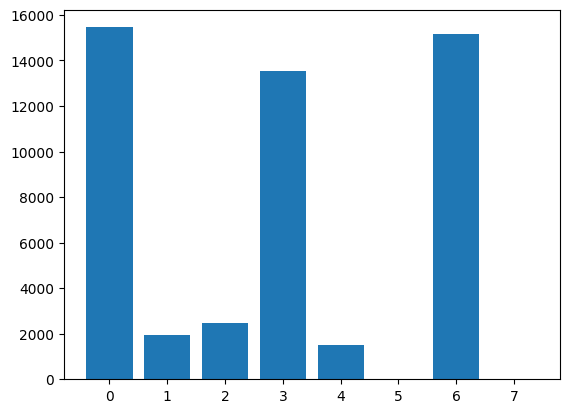

In [19]:
plt.bar(range(len(color_dsc.h)), color_dsc.h)

In [20]:
from shape_utils import linearize_edge

def get_colorized_edge(img, mask, palette):
    """
    img: np.array, RGB image
    mask: np.array, binary mask
    palette: np.array of shape (M, 3) - color centers from the LAB space
    """
    edge_1d = linearize_edge(mask)
    colorized_edge = np.zeros(img.shape)
    colorized_edge_1d = np.zeros((edge_1d.shape[0], 3))
    
    lab_frag = rgb2lab(img)
    for i, point in enumerate(edge_1d):
        color = lab_frag[point[0], point[1]]
        argmin = np.argmin(np.linalg.norm(palette - color, axis=1))
        q_color = palette[argmin]
        colorized_edge[point[0], point[1]] = color
        colorized_edge_1d[i] = color  #!
    
    return edge_1d, colorized_edge_1d, lab2rgb(colorized_edge)

In [21]:
def convert_fragment_to_data_structure(
    data_dir: str, 
    mask_index: int, 
    output_dir: str,
    model,
    palette, 
    ext_step=30
):
    frag, extended_frag, mask, extended_mask = read_fragment(data_dir, mask_index, model, ext_step)
    color_dsc = compute_color_dsc(frag, mask, palette)
    edge_coords, colorized_edge1, _ = get_colorized_edge(extended_frag, mask, palette)
    
    p = Path(output_dir).joinpath(str(mask_index))
    p.mkdir(parents=True, exist_ok=True)
    
    imsave(p / 'frag.png', frag)
    imsave(p / 'extended_frag.png', extended_frag)
    imsave(p / 'mask.png', mask)
    imsave(p / 'extended_mask.png', extended_mask)
    np.save(p / 'color_dsc_h.npy', color_dsc.h)
    np.save(p / 'color_dsc_b.npy', color_dsc.b)
    np.save(p / 'color_dsc_var.npy', color_dsc.var)
    np.save(p / 'edge_coords.npy', edge_coords)
    np.save(p / 'colorized_edge.npy', colorized_edge1)
    

In [22]:
convert_fragment_to_data_structure(data_dir, 14, "../../dataset", model, palette)

/tmp/ipykernel_468/506855048.py:18: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/14/mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'mask.png', mask)
/tmp/ipykernel_468/506855048.py:19: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/14/extended_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'extended_mask.png', extended_mask)


In [25]:
for i in range(15, 40):
    try: 
        convert_fragment_to_data_structure(data_dir, i, "../../dataset", model, palette)
    except FileNotFoundError:
        print(f'File not found {i}')

/tmp/ipykernel_468/506855048.py:18: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/15/mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'mask.png', mask)
/tmp/ipykernel_468/506855048.py:19: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/15/extended_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'extended_mask.png', extended_mask)
/tmp/ipykernel_468/506855048.py:18: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/16/mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'mask.png', mask)
/tmp/ipykernel_468/506855048.py:19: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/16/extended_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, 

File not found 18


/tmp/ipykernel_468/506855048.py:18: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/19/mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'mask.png', mask)
/tmp/ipykernel_468/506855048.py:19: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/19/extended_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'extended_mask.png', extended_mask)
/tmp/ipykernel_468/506855048.py:18: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/20/mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'mask.png', mask)
/tmp/ipykernel_468/506855048.py:19: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/20/extended_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, 

/tmp/ipykernel_468/506855048.py:18: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/31/mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'mask.png', mask)
/tmp/ipykernel_468/506855048.py:19: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/31/extended_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'extended_mask.png', extended_mask)
/tmp/ipykernel_468/506855048.py:18: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/32/mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(p / 'mask.png', mask)
/tmp/ipykernel_468/506855048.py:19: UserWarning: /mnt/c/Users/dev/Documents/fresco/dataset/32/extended_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, 

In [17]:
cedge_1d, cedge_2d = get_colorized_edge(extended_frag, mask, palette)

ValueError: too many values to unpack (expected 2)

In [18]:
plt.imshow(cedge_2d)

NameError: name 'cedge_2d' is not defined

In [19]:
output_dir = '../dataset'
p = Path(output_dir).joinpath(str(0))
print(p)

../dataset/0
